In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from datasets import load_dataset
import torch
from torch.nn.functional import cross_entropy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix, binary_f1_score
from copy import deepcopy, copy
import seaborn as sns
import pandas as pd
from huggingface_hub import notebook_login
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict, deque
from sklearn.model_selection import train_test_split
import random
from sentence_transformers import SentenceTransformer, InputExample, losses, evaluation

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")

import re
from typing import List, Dict
    
from src.preprocessing.sequence_classification.dataset import get_n_shots_per_class
from src.preprocessing.sequence_classification.set_fit_dataset import SetFitDataset
from src.model.sequence_classification.setfit_trainer import SetFitTrainer
import warnings
warnings.filterwarnings("ignore")

In [3]:
notebook_login()

In [4]:
!mkdir logs
model_name = "SetFit"
dataset_name = "RAFT-WIKI-QA"
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
# logging.basicConfig(filename=f'logs/{model_name}_{dataset_name}.log', encoding='utf-8', level= logging.INFO)

mkdir: cannot create directory ‘logs’: File exists


## SetFit

In [5]:
model = SentenceTransformer("whaleloops/phrase-bert",
                            cache_folder= "/Data/pedro.silva/")

In [6]:
dataset = load_dataset(
    "wiki_qa", 
    cache_dir= "/Data/pedro.silva"
)

Generating test split:   0%|          | 0/6165 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2733 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20360 [00:00<?, ? examples/s]

In [8]:
classes_names = ["wrong", "correct"]

In [9]:
num_classes = len(dataset['train']\
    .features['label']\
    .names)

classes_names = dataset['train']\
    .features['label']\
    .names

num_classes

2

In [16]:
train_df_pandas = dataset['train'].to_pandas()


In [17]:
proportion = train_df_pandas['label'].value_counts()/len(train_df_pandas)

In [18]:
proportion

label
0    0.948919
1    0.051081
Name: count, dtype: float64

In [19]:
train_df_pandas['text'] = train_df_pandas['question']+train_df_pandas['answer']
train_df_pandas

,question_id,question,document_title,answer,label,text
0,Q1,how are glacier caves formed?,Glacier cave,A partly submerged glacier cave on Perito More...,0,how are glacier caves formed?A partly submerge...
1,Q1,how are glacier caves formed?,Glacier cave,The ice facade is approximately 60 m high,0,how are glacier caves formed?The ice facade is...
2,Q1,how are glacier caves formed?,Glacier cave,Ice formations in the Titlis glacier cave,0,how are glacier caves formed?Ice formations in...
3,Q1,how are glacier caves formed?,Glacier cave,A glacier cave is a cave formed within the ice...,1,how are glacier caves formed?A glacier cave is...
4,Q1,how are glacier caves formed?,Glacier cave,"Glacier caves are often called ice caves , but...",0,how are glacier caves formed?Glacier caves are...
...,...,...,...,...,...,...
20355,Q3043,what is section eight housing,Section 8 (housing),A tenant who leaves a subsidized project will ...,0,what is section eight housingA tenant who leav...
20356,Q3043,what is section eight housing,Section 8 (housing),The United States Department of Housing and Ur...,0,what is section eight housingThe United States...
20357,Q3044,what is the main type of restaurant,Category:Types of restaurants,Restaurants categorized by type and informatio...,0,what is the main type of restaurantRestaurants...
20358,Q3046,what is us dollar worth based on,History of the United States dollar,U.S. Federal Reserve notes in the mid-1990s,0,what is us dollar worth based onU.S. Federal R...


In [44]:
def stratified_train_test_split(
    dataset : Dataset,
    classes : np.ndarray,
    train_size : float
):
    """Performs train test split keeping class distributions

    Args:
        dataset (Dataset): _description_
        classes (np.ndarray): _description_
        train_size (float): _description_

    Returns:
        _type_: _description_
    """    

    if isinstance(dataset, pd.DataFrame):
        df = dataset

    else:
        df = dataset.to_pandas()
        
    indexes_dict = {}
    for label in classes[0]:
        indexes_dict[label] = df.query(f"label == {label}")


    
    train_data = {
        'label': [],
        'text': []
    }

    validation_data = {
        "label" : [],
        "text": []
    }

    class_proportion = df['label'].value_counts()/len(df)

    # generating train data
    for label in classes[0]:
        n = len(indexes_dict[label])

        if isinstance(train_size, int):
            size = round(class_proportion[label] * train_size)
            
        else:
            size = int(train_size * n)

        train_data['text'] += df.query(f"label == {label}")\
            [0:size]\
            ['text']\
            .to_list()
        
        train_data['label'] += [label]*size
        
        validation_data['text'] +=df.query(f"label == {label}")\
            [size:]\
            ['text']\
            .to_list()
        
        validation_data['label'] += [label]* (n-size)

    return train_data, validation_data

## Few shot learning approach - 50 shots

In [45]:
classes = np.unique(dataset['train']['label'], return_counts=True)

n_shots = 50

train_validation, test_df = stratified_train_test_split(
    train_df_pandas,
    classes,
    train_size = n_shots
)
train_df, val_df = stratified_train_test_split(
    pd.DataFrame(train_validation),
    classes,
    30
)

In [46]:
val_df = pd.DataFrame(val_df).to_dict('list')
test_df = pd.DataFrame(test_df).sample(n = 1000).to_dict('list')

In [47]:
X_train, y_train = get_n_shots_per_class(
    train_df['text'],
    train_df['label'],
    n_shots = min(np.bincount(train_df['label'])),
    num_classes= num_classes
)
X_val, y_val = get_n_shots_per_class(
    val_df['text'], 
    val_df['label'],
    n_shots = min(50,min(np.bincount(val_df['label']))),
    num_classes=num_classes
)

In [52]:
set_fit_data_train = SetFitDataset(
    # train_df['text'],
    # train_df['label'], 
    X_train,
    y_train,
    input_example_format= True
    # R = 5
)

set_fit_data_val = SetFitDataset(
    val_df['text'], 
    val_df['label'],
    # X_val,
    # y_val,
    # R = 5,
    input_example_format= False
)

In [53]:
train_dataloader = DataLoader(
    set_fit_data_train.data,
    shuffle=True
)

val_dataloader = DataLoader(
    set_fit_data_val
)

In [54]:
from IPython.display import clear_output

## Training embedding

In [55]:
class CLF(torch.nn.Module):
    def __init__(
        self,
        in_features : int,
        out_features : int, 
        *args, 
        **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)

        self.layer1 = torch.nn.Linear(in_features, 512)
        self.relu = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(512, 256)
        self.layer3 = torch.nn.Linear(256, out_features)

    def forward(self, x : torch.Tensor):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        return self.layer3(x)
    

In [56]:
embedding_model = SentenceTransformer(
    "whaleloops/phrase-bert",
    cache_folder="/Data/pedro.silva/"
).to(device)

in_features = embedding_model.get_sentence_embedding_dimension()

clf = CLF(
    in_features,
    num_classes,
).to(device)



trainer = SetFitTrainer(
    embedding_model,
    clf,
    dataset_name,
    "phrase-bert",
    num_classes
)

In [57]:
trainer.train_embedding(
    train_dataloader,
    val_dataloader,
    n_shots,
    n_epochs=15,
    save = False
)

f1 score: 0.8783382773399353
metric: 0.09922896467351475
tensor([[  1,  18],
        [ 23, 148]], device='cuda:0')


In [58]:
trainer.best_model.save_to_hub(f"peulsilva/{trainer.model_name}-setfit-{n_shots}shots-{trainer.dataset_name}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Cloning https://huggingface.

Upload file model.safetensors:   0%|          | 1.00/418M [00:00<?, ?B/s]

To https://huggingface.co/peulsilva/phrase-bert-setfit-50shots-RAFT-WIKI-QA
   32eead2..f86315f  main -> main

   32eead2..f86315f  main -> main

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'https://huggingface.co/peulsilva/phrase-bert-setfit-50shots-RAFT-WIKI-QA/commit/f86315f7765180a4f9f5e686cb639078891634ae'

### Training classifier 

In [59]:
from random import shuffle
def shuffle_two_lists(X, y ):
    X_shuff = []
    y_shuff = []
    index_shuf = list(range(len(X)))
    shuffle(index_shuf)
    for i in index_shuf:
        X_shuff.append(X[i])
        y_shuff.append(y[i])


    return X_shuff, y_shuff


In [60]:
from src.utils import FocalLoss

In [61]:
_, class_counts = np.unique(
    train_df['label'],
    return_counts=True,
)

alpha = len(train_df['label'])/class_counts

In [76]:
embedding_model = SentenceTransformer(
    f"peulsilva/phrase-bert-setfit-{n_shots}shots-{dataset_name}",
    cache_folder='/Data/pedro.silva/'
).to(device)

# embedding_model = trainer.best_model

X_train_shuffled , y_train_shuffled = shuffle_two_lists(
    train_df['text'], 
    train_df['label']
)

history, embedding_model, clf = trainer.train_classifier(
    X_train_shuffled,
    y_train_shuffled,
    val_df['text'],
    val_df['label'],
    loss_fn= FocalLoss(alpha,1),
    clf = CLF(in_features, num_classes),
    embedding_model=embedding_model,
    n_epochs=15,
    lr = 1e-3
)

---------Epoch: 14-----------
f1 score: 0.4000000059604645
tensor([[16,  3],
        [ 0,  1]], device='cuda:0')


In [77]:
best_epoch = 0
best_f1 = np.max(history)
for idx, f1 in enumerate(history):
    if f1 == best_f1.item():
        best_epoch = idx

In [78]:
best_epoch

14

Text(0.5, 1.0, 'SetFit training results- AG news - 5 shots')

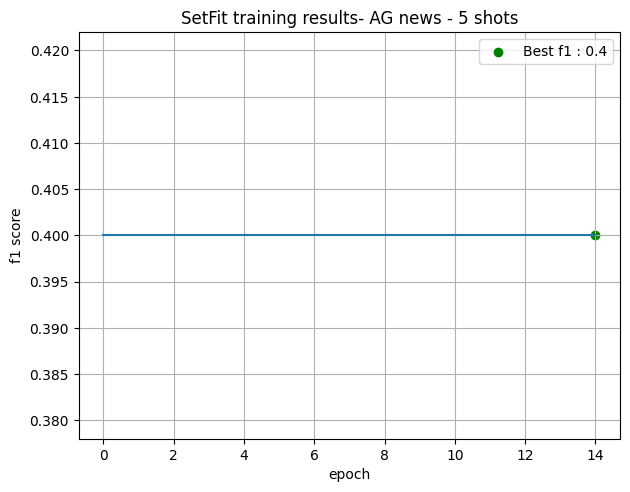

In [79]:
# history = ([k.to('cpu').numpy() for k in history])
plt.plot(history)
plt.scatter(
    [best_epoch], 
    best_f1.item(),
    color = "green",
    label = f"Best f1 : {round(best_f1.item(),3)}"
)
plt.grid()
plt.legend()
plt.ylabel("f1 score")
plt.xlabel("epoch")
plt.tight_layout()
plt.title("SetFit training results- AG news - 5 shots")

## Inference

In [81]:
y_true_val = torch.tensor([],device=device)
y_pred_val = torch.tensor([],device=device)


with torch.no_grad():
    for i in tqdm(range(len(test_df['label']))):
        text = test_df['text'][i]
        label = torch.tensor(test_df['label'][i])\
            .to(device)

        with torch.no_grad():
            embedding = embedding_model.encode(text, convert_to_tensor=True)

            y_pred = trainer.best_clf(embedding)\
                .argmax()
            
            y_pred_val = torch.cat([
                y_pred_val, 
                torch.tensor([y_pred]).to(device)
            ])

            y_true_val = torch.cat([
                y_true_val, 
                torch.tensor([test_df['label'][i]]).to(device)
            ])
            
f1 = binary_f1_score(
    y_pred_val,
    y_true_val,
    # num_classes=num_classes
)



  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:08<00:00, 112.83it/s]


In [82]:
conf_matrix = multiclass_confusion_matrix(
    y_pred_val.to(torch.int64),
    y_true_val.to(torch.int64),
    num_classes
)

In [83]:
f1

tensor(0.0845, device='cuda:0')

In [84]:
conf_matrix

tensor([[864,  89],
        [ 41,   6]], device='cuda:0')

Text(0.5, 1.0, 'Confusion Matrix RAFT-WIKI-QA - SetFit - 50 shots')

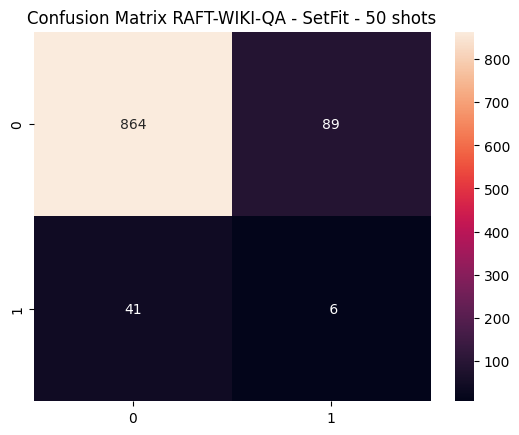

In [85]:
df = pd.DataFrame(
    conf_matrix.to("cpu").numpy(),
    index = classes_names,
    columns=classes_names
    
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title(f"Confusion Matrix {dataset_name} - SetFit - {n_shots} shots")

## General study 

In [87]:
classes = np.unique(dataset['train']['label'], return_counts=True)

n_shots = 500

train_validation, test_df = stratified_train_test_split(
    train_df_pandas,
    classes,
    train_size = n_shots
)
train_df, val_df = stratified_train_test_split(
    pd.DataFrame(train_validation),
    classes,
    300
)

In [88]:
val_df = pd.DataFrame(val_df).to_dict('list')
test_df = pd.DataFrame(test_df).sample(n = 1000).to_dict('list')

In [89]:
X_train, y_train = get_n_shots_per_class(
    train_df['text'],
    train_df['label'], 
    n_shots = min(25,min(np.bincount(train_df['label']))),
    num_classes= num_classes
)
X_val, y_val = get_n_shots_per_class(
    val_df['text'], 
    val_df['label'],
    n_shots = min(25,min(np.bincount(val_df['label']))),
    num_classes=num_classes
)

In [100]:
32*31/2

496.0

In [99]:
np.bincount(train_df['label'])

array([284,  16])

In [90]:
set_fit_data_train = SetFitDataset(
    X_train, 
    y_train,
    input_example_format= True,
)

set_fit_data_val = SetFitDataset(
    X_val, 
    y_val,
    input_example_format= False
)

In [103]:
train_dataloader = DataLoader(
    set_fit_data_train.data,
    shuffle=False
)

val_dataloader = DataLoader(
    set_fit_data_val
)

In [104]:
from IPython.display import clear_output

## Training embedding

In [105]:
class CLF(torch.nn.Module):
    def __init__(
        self,
        in_features : int,
        out_features : int, 
        *args, 
        **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)

        self.layer1 = torch.nn.Linear(in_features, 512)
        self.relu = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(512, 256)
        self.layer3 = torch.nn.Linear(256, out_features)

    def forward(self, x : torch.Tensor):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        return self.layer3(x)
    

In [106]:
embedding_model = SentenceTransformer(
    "whaleloops/phrase-bert",
    cache_folder="/Data/pedro.silva/"
).to(device)

in_features = embedding_model.get_sentence_embedding_dimension()

clf = CLF(
    in_features,
    num_classes,
).to(device)



trainer = SetFitTrainer(
    embedding_model,
    clf,
    dataset_name,
    "phrase-bert",
    num_classes
)

In [107]:
trainer.train_embedding(
    train_dataloader,
    val_dataloader,
    n_shots,
    n_epochs=5,
    save = False
)

f1 score: 0.6428571939468384
metric: 0.0
tensor([[  0, 100],
        [  0,  90]], device='cuda:0')


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/496 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [108]:
trainer.best_model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': None}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [109]:
trainer.best_model.save_to_hub(f"peulsilva/{trainer.model_name}-setfit-{n_shots}shots-{trainer.dataset_name}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Cloning https://huggingface.

Upload file model.safetensors:   0%|          | 1.00/418M [00:00<?, ?B/s]

To https://huggingface.co/peulsilva/phrase-bert-setfit-500shots-RAFT-WIKI-QA
   eb5df1b..1ee74c7  main -> main

   eb5df1b..1ee74c7  main -> main

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'https://huggingface.co/peulsilva/phrase-bert-setfit-500shots-RAFT-WIKI-QA/commit/1ee74c7ee0f01bcf355f7002652c2fc67b37c391'

### Training classifier 

In [110]:
from random import shuffle
def shuffle_two_lists(X, y ):
    X_shuff = []
    y_shuff = []
    index_shuf = list(range(len(X)))
    shuffle(index_shuf)
    for i in index_shuf:
        X_shuff.append(X[i])
        y_shuff.append(y[i])


    return X_shuff, y_shuff


In [111]:
from src.utils import FocalLoss

In [112]:
_, class_counts = np.unique(
    train_df['label'],
    return_counts=True,
)

alpha = len(train_df['label'])/class_counts

In [128]:
# embedding_model = SentenceTransformer(
#     f"peulsilva/phrase-bert-setfit-{n_shots}shots-{dataset_name}",
#     cache_folder='/Data/pedro.silva/'
# ).to(device)

embedding_model = trainer.best_model

X_train_shuffled , y_train_shuffled = shuffle_two_lists(
    train_df['text'], 
    train_df['label']
)

history, embedding_model, clf = trainer.train_classifier(
    X_train_shuffled,
    y_train_shuffled,
    val_df['text'],
    val_df['label'],
    loss_fn= FocalLoss(alpha,1),
    clf = CLF(in_features, num_classes),
    embedding_model=embedding_model,
    n_epochs=10,
    lr = 1e-3
)

---------Epoch: 9-----------
f1 score: 0.1111111119389534
tensor([[132,  58],
        [  6,   4]], device='cuda:0')


In [129]:
best_epoch = 0
best_f1 = np.max(history)
for idx, f1 in enumerate(history):
    if f1 == best_f1.item():
        best_epoch = idx

In [130]:
best_epoch

1

Text(0.5, 1.0, 'SetFit training results- AG news - 5 shots')

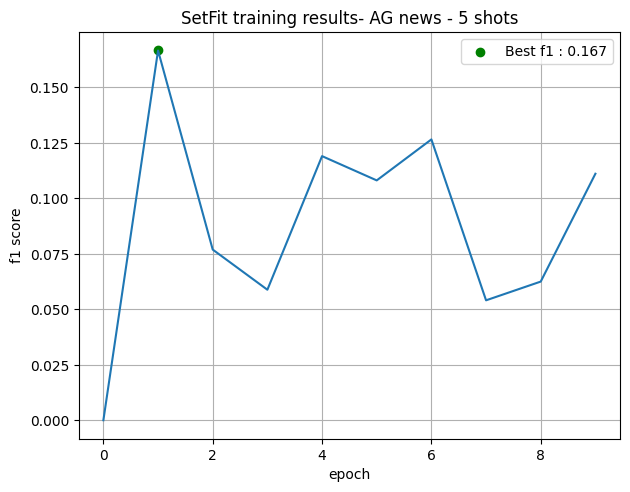

In [132]:
# history = ([k.to('cpu').numpy() for k in history])
plt.plot(history)
plt.scatter(
    [best_epoch], 
    best_f1.item(),
    color = "green",
    label = f"Best f1 : {round(best_f1.item(),3)}"
)
plt.grid()
plt.legend()
plt.ylabel("f1 score")
plt.xlabel("epoch")
plt.tight_layout()
plt.title("SetFit training results- AG news - 5 shots")

## Inference

In [133]:
y_true_val = torch.tensor([],device=device)
y_pred_val = torch.tensor([],device=device)


for i in tqdm(range(len(test_df['label']))):
    text = test_df['text'][i]
    label = torch.tensor(test_df['label'][i])\
        .to(device)

    with torch.no_grad():
        embedding = embedding_model.encode(text, convert_to_tensor=True)

        y_pred = trainer.best_clf(embedding)\
            .argmax()
        
        y_pred_val = torch.cat([
            y_pred_val, 
            torch.tensor([y_pred]).to(device)
        ])

        y_true_val = torch.cat([
            y_true_val, 
            torch.tensor([test_df['label'][i]]).to(device)
        ])
        
f1 = binary_f1_score(
    y_pred_val,
    y_true_val,
    # num_classes=num_classes
)



  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:08<00:00, 117.83it/s]


In [134]:
f1

tensor(0.1429, device='cuda:0')

In [137]:
multiclass_confusion_matrix(
    y_pred_val.to(torch.int64),
    y_true_val.to(torch.int64),
    num_classes=num_classes
)

tensor([[714, 221],
        [ 43,  22]], device='cuda:0')